In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC, NuSVC
from scipy import stats
from constants import *
from auxiliary_functions import plot_labeled_data_1d, plot_labeled_data_2d, plot_labeled_data_3d, evaluate_classifier_cv
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from collections import namedtuple
from sklearn.decomposition import PCA
from os import cpu_count
from TwoGroupsWeightedModel import TwoGroupsWeightedModel
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

#Load and parse data sets

In [4]:
process_data_files = False  # if set to False, data will be loaded from saved files

##Kaggle Data

  BirthYear     DA DiagnosisYear  Gender          ID  Impact Levadopa   MAOB  \
0      1952   True          2000  Female  0EA27ICBLF  Severe     True  False   
1      1959  False        ------  Female  0QAZFRHQHW  ------    False  False   
2      1946  False        ------  Female  0WTDIGPSBZ  ------    False  False   
3      1944  False        ------    Male  1HOEBIGASW  ------    False  False   
4      1953  False          2017    Male  1WMVCCU4RH  Medium    False  False   

   Other Parkinsons Sided Tremors       UPDRS  
0  False       True  Left    True  Don't know  
1  False      False  None   False  Don't know  
2  False      False  None   False  Don't know  
3  False      False  None   False  Don't know  
4  False       True  Left    True  Don't know  


Loading taps files: 100/622


Loading taps files: 200/622


Loading taps files: 300/622


Loading taps files: 400/622


Loading taps files: 500/622


Loading taps files: 600/622


Filtered out 386 rows with bad values in column 'HoldTime'


Filtered out 167 rows with bad values in column 'LatencyTime'


Filtered out 196 rows with bad values in column 'FlightTime'


Filtered out 0 rows with bad values in column 'Direction'


Filtered out 0 rows with bad values in column 'Hand'


there are 50 unique user IDs in the Tappy data with no entry in the Users file


Filtered out 301925 rows with bad values in column 'ID'


           ID    Date     TimeStamp Hand HoldTime Direction LatencyTime  \
0  0EA27ICBLF  160722  18:41:04.336    L    101.6        LL       234.4   
1  0EA27ICBLF  160722  18:42:14.070    L     85.9        LL       437.5   
2  0EA27ICBLF  160722  18:42:14.273    L     78.1        LL       210.9   
3  0EA27ICBLF  160722  18:42:14.617    L     62.5        LL       359.4   
4  0EA27ICBLF  160722  18:42:15.586    S      125        LS       187.5   

  FlightTime  
0      156.3  
1      359.4  
2        125  
3      281.3  
4       93.8  


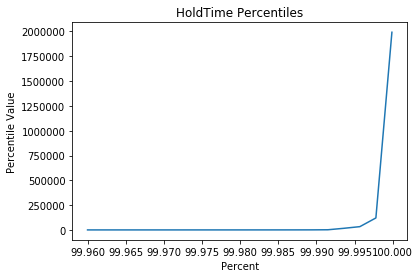

Filtered out 631 rows with outliers in column 'HoldTime'
Starting parsing of timestamps into cumulative time...


Filtered out 0 rows with bad values in column 'PressTimeCumulative'
Parsing ended, took 812.93 seconds


  FlightTime          ID Hand Direction LatencyTime HoldTime binIndex
0      156.3  0EA27ICBLF    L        LL       234.4    101.6  (0, 90]
1      359.4  0EA27ICBLF    L        LL       437.5     85.9  (0, 90]
2        125  0EA27ICBLF    L        LL       210.9     78.1  (0, 90]
3      281.3  0EA27ICBLF    L        LL       359.4     62.5  (0, 90]
4       93.8  0EA27ICBLF    S        LS       187.5      125  (0, 90]


In [11]:
from KaggleDataLoader import *

if not process_data_files:
    kaggle_taps = pd.read_csv(KAGGLE_TAPS_INPUT)
    print("Kaggle taps dataframe:")
    print(kaggle_taps.head())
    kaggle_users = pd.read_csv(KAGGLE_USERS_INPUT)
    print("Kaggle users dataframe:")
    print(kaggle_users.head())
    

In [ ]:
if process_data_files:
    # Create dataframe from files, perform basic cleaning
    kaggle_users = create_merged_users_details_file()
    print(kaggle_users.head())


### Clean the data from bad values and incompatible data

In [ ]:
if process_data_files:
    kaggle_taps = create_merged_taps_dataframe()
    kaggle_taps = clean_bad_values(kaggle_taps)
    kaggle_taps = clean_incompatible_user_ids(kaggle_taps, kaggle_users)
    print(kaggle_taps.head())


### Filter outliers

In [ ]:
if process_data_files:
    # Filter outliers
    def filter_column_by_quantile(df, column, threshold):
        len_before = len(df)
        df = df[df[column] < np.percentile(df[column], threshold)]
        len_after = len(df)
        print("Filtered out {} rows with outliers in column '{}'".format((len_before - len_after), column))
        return df
    
    
    def plot_percentiles_of_column(df, col, start, end, bins):
        X = np.linspace(start, end, bins)
        Y = [np.percentile(df[col], x) for x in X]
        plt.plot(X, Y)
        plt.title(col + " Percentiles")
        plt.xlabel("Percent")
        plt.ylabel("Percentile Value")
        plt.show()
    
    
    # Filter out outliers of HoldTime:
    plot_percentiles_of_column(kaggle_taps, 'HoldTime', 99.96, 99.9999, 20)

In [ ]:
if process_data_files:
    kaggle_taps = filter_column_by_quantile(kaggle_taps, 'HoldTime', 99.993)


### 3. Calculate cumulative time to be used in method 2 later as a time series bagging method

In [ ]:
if process_data_files:
    # Add parsed date and time column + calculate cumulative time
    kaggle_taps = add_cumulative_timestamps_column(kaggle_taps)
    
    
    # Group to bin indexes by the cumulative timestamps
    def build_bins(df, bin_size_seconds):
        df["PressTimeCumulative"] = df["PressTimeCumulative"] / 1000
        max_press = (int(max((df["PressTimeCumulative"])) / bin_size_seconds) + 1) * bin_size_seconds + 1
        user_bins = [i for i in range(0, max_press, bin_size_seconds)]
        df["binIndex"] = pd.cut((df["PressTimeCumulative"]), user_bins)
        return df
    
    
    kaggle_taps = build_bins(kaggle_taps, 90)
    

### 4. Save to file

In [ ]:
if process_data_files:    
    # Keep only necessary columns and save to file
    kaggle_taps = kaggle_taps[TAPS_FINAL_COLUMNS + ['binIndex']]    
    kaggle_taps.to_csv(constants.KAGGLE_TAPS_INPUT, index=False)

    print(kaggle_taps.head())

####Kaggle data statistics in plots

In [ ]:
from plots import *
kaggle_users = pd.read_csv(KAGGLE_USERS_INPUT) #todo: remove
kaggle_taps = pd.read_csv(KAGGLE_TAPS_INPUT) #todo: remove


ages = add_age_column(kaggle_users)
mild_users = keep_only_mild_users(kaggle_users)

# general statistics of the users
ages_plot(ages)
genders_plot(mild_users)
diagnosis_plot(mild_users)
sickness_level_plot(ages)
show_plots()





##MIT Data

Filtered out 1 rows with bad values in column 'HoldTime'


Filtered out 3504 rows with bad values in column 'LatencyTime'


Filtered out 12987 rows with bad values in column 'FlightTime'


Filtered out 0 rows with bad values in column 'pressTime'


Filtered out 10664 rows with bad values in column 'Hand'


Filtered out 16481 rows with bad values in column 'Direction'


   ID Hand Direction HoldTime  LatencyTime FlightTime pressTime binIndex
1  68    R        LR   0.1194  1.40111e+09     1.7662    1.8314  (0, 90]
2  68    L        RL   0.1337       0.5904      0.471    2.4218  (0, 90]
3  68    L        LL   0.1847       0.4731     0.3394    2.8949  (0, 90]
4  68    L        LL   0.1499       0.3464     0.1617    3.2413  (0, 90]
5  68    R        LR   0.2137       0.7203     0.5704    3.9616  (0, 90]


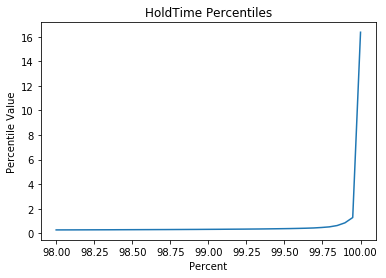

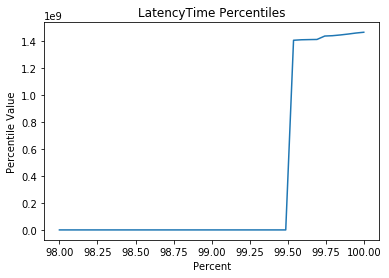

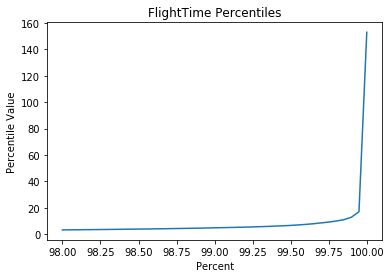

Filtered out 17 rows with outliers in column 'HoldTime'


Filtered out 966 rows with outliers in column 'LatencyTime'


Filtered out 81 rows with outliers in column 'FlightTime'
   ID Hand Direction HoldTime  LatencyTime FlightTime pressTime binIndex
1  68    R        LR    119.4  1.40111e+12     1766.2    1.8314  (0, 90]
2  68    L        RL    133.7        590.4        471    2.4218  (0, 90]
3  68    L        LL    184.7        473.1      339.4    2.8949  (0, 90]
4  68    L        LL    149.9        346.4      161.7    3.2413  (0, 90]
5  68    R        LR    213.7        720.3      570.4    3.9616  (0, 90]


   ID  Parkinsons  UPDRS
0  11        True  14.25
1  60       False   2.00
2  67        True  25.25
3  68       False   6.00
4  70        True  26.25


In [5]:
from MITDataLoader import *

if not process_data_files:
    mit_taps = pd.read_csv(MIT_TAPS_INPUT)
    print("MIT taps dataframe:")
    print(mit_taps.head())
    mit_users = pd.read_csv(MIT_USERS_INPUT)
    print("MIT users dataframe:")
    print(mit_users.head())


In [ ]:
### 1. Read from files + clean bad values

In [ ]:
if process_data_files:
    mit_users = pd.read_csv(USERS, delimiter=',', header=0, error_bad_lines=False,
                            low_memory=False, usecols=["pID", "gt", "updrs108", "file_1", "file_2"])
    
    mit_taps = create_merged_taps_dataframe()
    mit_taps = clean_errors_and_bad_values(mit_taps)
    

In [ ]:
### 2. Calculate time bins to be used later in method 2 as a time series bagging method

In [ ]:
if process_data_files:
    # Group to bin indexes by pressTime and add as a new column
    bin_size_seconds = 90
    max_press = (int(max(mit_taps["pressTime"]) / bin_size_seconds) + 1) * bin_size_seconds + 1
    user_bins = [i for i in range(0, max_press, bin_size_seconds)]
    mit_taps["binIndex"] = pd.cut(mit_taps["pressTime"], user_bins)
    print(mit_taps.head())
    

In [ ]:
### 3. Plot outliers

In [ ]:
if process_data_files:
    def plot_percentile(df, column, start, end, bins):
        X = np.linspace(start, end, bins)
        Y = [np.percentile(df[column], x) for x in X]
        plt.plot(X, Y)
        plt.title(column + " Percentiles")
        plt.xlabel("Percent")
        plt.ylabel("Percentile Value")
        plt.show()
    
    
    def filter_column_by_quantile(df, column, threshold):
        len_before = len(df)
        df = df[df[column] < np.percentile(df[column], threshold)]
        len_after = len(df)
        print("Filtered out {} rows with outliers in column '{}'".format((len_before - len_after), column))
    
    
    if SHOW_PLOTS:
        for col in list(set(FLOAT_COLUMNS) - {"pressTime"}):
            plot_percentile(mit_taps, col, 98, 99.9999, 40)


In [ ]:
### 4. Filter according to the results in the plots

In [ ]:
if process_data_files:
    filter_column_by_quantile(mit_taps, "HoldTime", 99.99)
    filter_column_by_quantile(mit_taps, "LatencyTime", 99.4)
    filter_column_by_quantile(mit_taps, "FlightTime", 99.95)


In [ ]:
### 5. Save final taps data frame to file

In [ ]:
if process_data_files:
    # Save to file - Taps file
    mit_taps[["HoldTime", "LatencyTime", "FlightTime"]] = \
        1000 * mit_taps[["HoldTime", "LatencyTime", "FlightTime"]]  # to milliseconds
    print(mit_taps.head())
    
    mit_taps.to_csv(MIT_TAPS_INPUT, index=False)


In [ ]:
### 6. Save final users data frame to file

In [ ]:
if process_data_files: 
    # Save to file - Users file
    mit_users.rename(columns={'pID': 'ID', 'gt': 'Parkinsons', 'updrs108': 'UPDRS'}, inplace=True)
    mit_users = mit_users[['ID', 'Parkinsons', 'UPDRS']]
    print(mit_users.head())
    
    mit_users.to_csv(MIT_USERS_INPUT, index=False)

####MIT data statistics in plots

C:\Users\Nili\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


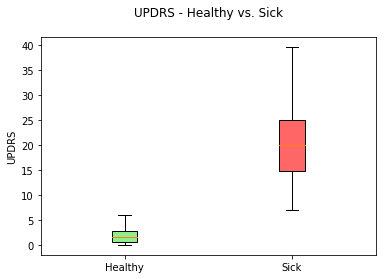

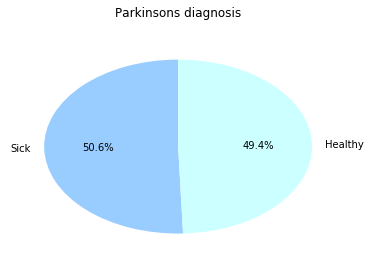

In [5]:
from plots import mit_updrs_distribution

mit_users = pd.read_csv(MIT_USERS_INPUT) #todo: remove
mit_taps = pd.read_csv(MIT_TAPS_INPUT) #todo: remove

mit_updrs_distribution(mit_users)
mit_diagnosis(mit_users)



#Feature Creation

##1.Creating features from the Kaggle data set, according to the first method:

In [6]:
# Load the raw data, after cleaning:
from method1_feature_extraction import *

raw_kaggle_data = pd.read_csv(KAGGLE_TAPS_INPUT)
kaggle_users_data = pd.read_csv(KAGGLE_USERS_INPUT)

In [8]:
# For every patient, calculate summary statistics for all of their data, partitioned into Left/Right, 
# and LR/RL/LL/RR transitions: 
method1_features = create_summary_statistics(raw_kaggle_data,
                                             columns_to_aggregate=["FlightTime", "HoldTime", "LatencyTime"],
                                             aggregation_functions=[np.mean, np.std, stats.kurtosis, stats.skew,
                                                        stats.entropy, percnt10, percnt20, percnt40, percnt60, percnt70,
                                                        percnt80, percnt90])
# Add a feature of the mean-diff between Left and Right HoldTimes, and Between LR and RL LatencyTimes:
method1_features["mean_diff_L_R_HoldTime"] = method1_features.R_HoldTime_mean - method1_features.L_HoldTime_mean
method1_features["mean_diff_LR_RL_LatencyTime"] = method1_features.RL_LatencyTime_mean - method1_features.LR_LatencyTime_mean
method1_features["mean_diff_LL_RR_LatencyTime"] = method1_features.LL_LatencyTime_mean - method1_features.RR_LatencyTime_mean

# Join with the Users data:
method1_features = method1_features.merge(kaggle_users_data, on="ID", how="left")
# Dump to csv:
method1_features.to_csv(KAGGLE_DATA_ARTICLE_METHOD1_FEATURES)
print(method1_features.head())


           ID  L_FlightTime_mean  L_FlightTime_std  L_FlightTime_kurtosis  \
0  0EA27ICBLF         239.655394        107.822976              -1.263192   
1  0QAZFRHQHW         319.277429        162.896291              -0.659685   
2  1HOEBIGASW         386.722581        175.209404              -0.927794   
3  1XNJCXS3EY         226.013786         85.352172              -0.493719   
4  2JTCBKUP8T         265.411441        160.215877              -0.093353   

   L_FlightTime_skew  L_FlightTime_entropy  L_FlightTime_percnt10  \
0          -0.032858             11.148338                   93.8   
1           0.361020              6.322468                  117.2   
2          -0.326568              3.319654                  132.8   
3          -0.125464              6.045913                  113.3   
4           0.540118              8.959632                   54.7   

   L_FlightTime_percnt20  L_FlightTime_percnt40  L_FlightTime_percnt60  \
0                  125.0                 203.10 

In [ ]:
from plots import *

method1_features = pd.read_csv(KAGGLE_DATA_ARTICLE_METHOD1_FEATURES) #todo: remove




In [10]:
# Filter the data so that we only keep patients with plenty of tapping events, and only patients with mild Parkinsons:
method1_features = method1_features[method1_features.total_count >= TAPS_THRESHOLD]  # take only users with more than THRESHOLD keystrokes
method1_features = method1_features[method1_features.Levadopa == False]
method1_features = method1_features[method1_features.Parkinsons == False | ( (method1_features.Parkinsons == True) & (method1_features.Impact == "Mild"))]


#Modeling Phase 1: Attempting to reproduce the results from the Kaggle challenge article

In [8]:
# The summary statistics used in the original article:
ARTICLE_EXPLANATORY_VARIABLES =['L_HoldTime_mean', 'L_HoldTime_std', 'L_HoldTime_kurtosis', 'L_HoldTime_skew',
 'R_HoldTime_mean', 'R_HoldTime_std', 'R_HoldTime_kurtosis', 'R_HoldTime_skew', 'LL_LatencyTime_mean', 'LL_LatencyTime_std',
 'LL_LatencyTime_kurtosis', 'LL_LatencyTime_skew', 'LR_LatencyTime_mean', 'LR_LatencyTime_std', 'LR_LatencyTime_kurtosis',
 'LR_LatencyTime_skew', 'RL_LatencyTime_mean', 'RL_LatencyTime_std', 'RL_LatencyTime_kurtosis', 'RL_LatencyTime_skew',
 'RR_LatencyTime_mean', 'RR_LatencyTime_std', 'RR_LatencyTime_kurtosis', 'RR_LatencyTime_skew', 'mean_diff_LR_RL_LatencyTime',
 'mean_diff_LL_RR_LatencyTime', 'mean_diff_L_R_HoldTime']




### First attempt: applying several models to the raw data with the variables used in the article, without further processing:


In [22]:
X = method1_features[ARTICLE_EXPLANATORY_VARIABLES]
y = method1_features["Parkinsons"]
classifiers = [LogisticRegression(),
               RandomForestClassifier(),
               AdaBoostClassifier(),
               KNeighborsClassifier(),
               GradientBoostingClassifier(),
               SVC(kernel='rbf', probability=True),
               ]
for clf in classifiers:
    accuracy = evaluate_classifier_cv(clf, X, y, cross_validation_folds=5)
    print(str(clf).split("(")[0]+":")
    print("\t"+accuracy.train)
    print("\t" + accuracy.test)

LogisticRegression:
	Train accuracy:0.7885
	Test accuracy (5-fold cross validation):0.4818
RandomForestClassifier:
	Train accuracy:0.9808
	Test accuracy (5-fold cross validation):0.5345


AdaBoostClassifier:
	Train accuracy:1.0
	Test accuracy (5-fold cross validation):0.52
KNeighborsClassifier:
	Train accuracy:0.6538
	Test accuracy (5-fold cross validation):0.4655


GradientBoostingClassifier:
	Train accuracy:1.0
	Test accuracy (5-fold cross validation):0.4782
SVC:
	Train accuracy:1.0
	Test accuracy (5-fold cross validation):0.6327


### Second attempt: normalize the data and apply PCA dimensionality reduction

In [ ]:
scaler = StandardScaler()
normalized_X = scaler.fit_transform(X)

In [14]:
# Visualizing the data in 3d, 2d and 1d after PCA:
pca = PCA(n_components=3)
reduced_X = pca.fit_transform(normalized_X)
plot_labeled_data_3d(reduced_X, y, "Casting to 3D using Principal Component Analysis")


pca = PCA(n_components=2)
reduced_X = pca.fit_transform(normalized_X)
plot_labeled_data_2d(reduced_X, y, "Casting to 2D using Principal Component Analysis")


pca = PCA(n_components=1)
reduced_X = pca.fit_transform(normalized_X)
plot_labeled_data_1d(reduced_X, y, "Casting to 1D using Principal Component Analysis")

NameError: name 'normalized_X' is not defined

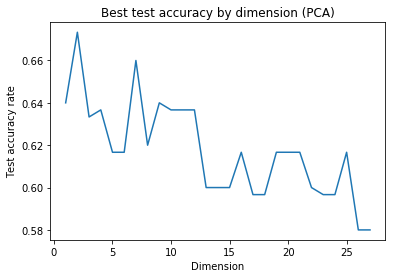

In [ ]:
original_dim = len(normalized_X[0])
tested_dimensions = []
accuracies = []
for dim in [i for i in range(1, original_dim+1)]:
    if dim != original_dim:
        pca = PCA(n_components=dim)
        reduced_X = pca.fit_transform(normalized_X, y.values)
    else:
        reduced_X = normalized_X
    best_accuracy = namedtuple("best_accuracy", "clf_name test_accuracy train_accuracy")
    best_accuracy.test_accuracy = -1  #init
    for clf in classifiers:
        accuracy = evaluate_classifier_cv(clf, reduced_X, y, cross_validation_folds=10)
        if accuracy.test_score > best_accuracy.test_accuracy:
            best_accuracy.test_accuracy = accuracy.test_score
            best_accuracy.clf_name = str(clf).split("(")[0]
    tested_dimensions.append(dim)
    accuracies.append(best_accuracy.test_accuracy)
plt.title("Best test accuracy by dimension (reduction with PCA))
plt.xlabel("Dimension")
plt.ylabel("Test accuracy rate")
plt.plot(tested_dimensions, accuracies)


In [24]:
lda = LinearDiscriminantAnalysis()
scaler = StandardScaler()

TRAIN_PERCENTAGE = 0.7
indices = [i for i in range(len(y))]
train_indices = np.random.choice(indices, size=int(TRAIN_PERCENTAGE*len(y)), replace=False)
test_indices = [i for i in indices if i not in train_indices]

train_X = scaler.fit_transform(X.iloc[train_indices])
train_y = y.iloc[train_indices].values.reshape(-1,1)

test_X = scaler.transform(X.iloc[test_indices])
test_y = y.iloc[test_indices].values.reshape(-1,1)

train_X = lda.fit_transform(train_X, train_y)
test_X = lda.transform(test_X)

C:\Python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Python36\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [29]:
best_auc, best_clf = get_best_roc(classifiers, train_X, train_y, test_X, test_y)
print("best AUC after LDA ddimensionality reduction:", best_auc)

# TODO:
    #1. fix warnings here
    #2. continue with splititing to two groups, and exactly following the first article
    #3. add the feature extraction of the second method (nqi features)
    #4. continue to second method.

best AUC after LDA ddimensionality reduction: 0.6


C:\Python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoav1\PycharmProjects\Parkinsons\auxiliary_functions.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_X, train_y)
C:\Python36\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoav1\PycharmProjects\Parkinsons\auxiliary_functions.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  model.fit(train